In [1]:
import pandas as pd
import numpy as np
import sqlite3
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy
import datetime
from tqdm import tqdm
import gc

## download data

In [2]:

ordersize_base = 600
exchange1_fee = 0.2

start = datetime.datetime(2022, 11, 1)
end = datetime.datetime(2022, 11,6)

#
sample_size = "1S" #S = seconds
books = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/books_GATEIO_AVAX-USDT_2022-11-01.parquet")
trades = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/trades_GATEIO_AVAX-USDT_2022-11-01.parquet")

# Filter the DataFrame
books = books[(books['received_time'] >= start) & (books['received_time'] <= end)]
trades = trades[(trades['received_time'] >= start) & (trades['received_time'] <= end)]

# Explicitly collect garbage
gc.collect()
books.head()

,origin_time,received_time,sequence_number,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,...,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,exchange,symbol
0,1970-01-01,2022-11-01 12:52:26.793037312,2473485388,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,19.196,64.6354,19.198,154.2370,19.200,83.4048,19.205,56.6429,GATEIO,AVAX-USDT
1,1970-01-01,2022-11-01 12:52:27.143308032,2473485405,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,19.193,260.5824,19.194,112.4247,19.196,64.6354,19.198,154.2370,GATEIO,AVAX-USDT
2,1970-01-01,2022-11-01 12:52:27.250262016,2473485405,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,19.193,260.5824,19.194,112.4247,19.196,64.6354,19.198,154.2370,GATEIO,AVAX-USDT
3,1970-01-01,2022-11-01 12:52:27.353878016,2473485397,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,19.196,64.6354,19.198,154.2370,19.200,83.4048,19.205,56.6429,GATEIO,AVAX-USDT
4,1970-01-01,2022-11-01 15:05:27.077800448,2473847826,18.791,470.9478,18.789,442.7291,18.781,51.7220,18.779,...,18.839,116.1659,18.840,53.0894,18.841,2.8054,18.845,83.4048,GATEIO,AVAX-USDT


In [3]:

def smallest_increment(number):

    # Convert the number to a string and split by the decimal point
    parts = str(number).split('.')
    
    # If there's a decimal part
    if len(parts) > 1:
        # Count the number of digits after the decimal point
        decimal_places = len(parts[1])
        
        # Return the smallest increment based on the decimal places
        return 10 ** -decimal_places
    else:
        # If there's no decimal, the smallest increment is 1
        return 1
tick_size = smallest_increment(trades["price"].iloc[0])
tick_size


books["mid"] = (books["bid_0_price"]+books["ask_0_price"])/2
books["spread"] = books["ask_0_price"] - books["bid_0_price"]
books["spread_pct"] = (books["spread"]/books["mid"])*100
books["spread_ticks"] = books["spread"]/tick_size

In [4]:
# delete trades inside of spread:
delete_fake = True

#percentage of trades within spread
def find_closest_timestamp(ts, ts_list):
    """Find the closest timestamp in ts_list to ts."""
    deltas = np.abs((ts_list - ts).total_seconds())
    return ts_list[np.argmin(deltas)]
    target = row.name + pd.Timedelta(seconds=5)
    return ts_index.get_loc(target, method='nearest')

tick_size = smallest_increment(trades["price"].iloc[0])
book1 = books.copy()
# Merge trades and l1 data
book1['future_bid'] = book1.bid_0_price.shift(-1)
book1['future_ask'] = book1.ask_0_price.shift(-1)
# book1['mid_future_5s'] = book1.mid.shift(-5)

df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = book1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)

# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

trades = df[["side","quantity","price","trade_received_time", "origin_time_x", "fake", "trade_id"]]
trades["received_time"] =trades["trade_received_time"]

if delete_fake:
    print("drop fake trades!")
    trades = trades[~trades["fake"]]

Fake trade percentage 11.064078038720881
Fake volume percentage 22.637278812909862
drop fake trades!


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_8670/1080341533.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["received_time"] =trades["trade_received_time"]


In [5]:
#vwap

def rolling_vwap(df, window):
    # Calculate the product of price and quantity
    df['price_quantity'] = df['price'] * df['quantity']
    
    # Calculate rolling sum of price_quantity and quantity
    rolling_price_quantity_sum = df['price_quantity'].rolling(window).sum()
    rolling_quantity_sum = df['quantity'].rolling(window).sum()
    
    # Calculate rolling VWAP
    rolling_vwap = rolling_price_quantity_sum / rolling_quantity_sum
    
    return rolling_vwap

# Call the function with a window size, for example, 3
trades['rolling_vwap_5_trades'] = rolling_vwap(trades, 5)
trades['rolling_vwap_20_trades'] = rolling_vwap(trades, 20)
trades['rolling_vwap_50_trades'] = rolling_vwap(trades, 50)
trades['rolling_vwap_100_trades'] = rolling_vwap(trades, 100)


In [6]:
trades.set_index('received_time', inplace=True)
books = pd.merge_asof(books, trades[["rolling_vwap_5_trades","rolling_vwap_20_trades",'rolling_vwap_50_trades','rolling_vwap_100_trades']], on='received_time', direction='backward') #backward-> no future information
trades = trades.reset_index()

In [7]:
#imbalance
amount_of_rows = 3
books['ob_imbalance_3'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

In [8]:
#limit imbalance
for i in range(5):
    books[f"bid_{i}_size_diff"] = books[f"bid_{i}_size"] - books[f"bid_{i}_size"].shift(+1)
    books[f"ask_{i}_size_diff"] = books[f"ask_{i}_size"] - books[f"ask_{i}_size"].shift(+1)

combined_df = pd.concat([books, trades], ignore_index=True)
sorted_df = combined_df.sort_values(by='received_time')

window = "5S"


sorted_df.set_index('received_time', inplace=True)

# Create a mask for rows where side is not nan and side is 'sell'
mask = (~sorted_df['side'].isna()) & (sorted_df['side'] == 'sell')

# Set quantity to 0 where the mask is False
sorted_df['quantity_buy'] = np.where(mask, sorted_df['quantity'], 0)

# Create a rolling window object
rolling_window = sorted_df.rolling(window)

# Calculate the rolling cumulative sum for the specified columns
sorted_df['bid_diff_sum'] = sorted_df['bid_0_size_diff'] + sorted_df['bid_1_size_diff'] + sorted_df['bid_2_size_diff'] + sorted_df['bid_3_size_diff'] + sorted_df['bid_4_size_diff']

sorted_df['rolling_bid_diff_sum'] = rolling_window['bid_diff_sum'].sum()

# Add the rolling sum of the quantity column to the rolling windows
sorted_df['rolling_bid_diff_sum'] += rolling_window['quantity_buy'].sum()

#same for ask
# Create a mask for rows where side is not nan and side is 'sell'
mask = (~sorted_df['side'].isna()) & (sorted_df['side'] == 'buy')

# Set quantity to 0 where the mask is False
sorted_df['quantity_sell'] = np.where(mask, sorted_df['quantity'], 0)

# Create a rolling window object
rolling_window = sorted_df.rolling(window)

# Calculate the rolling cumulative sum for the specified columns
sorted_df['ask_diff_sum'] = sorted_df['ask_0_size_diff'] + sorted_df['ask_1_size_diff'] + sorted_df['ask_2_size_diff'] + sorted_df['ask_3_size_diff'] + sorted_df['ask_4_size_diff']

sorted_df['rolling_ask_diff_sum'] = rolling_window['ask_diff_sum'].sum()

# Add the rolling sum of the quantity column to the rolling windows
sorted_df['rolling_ask_diff_sum'] += rolling_window['quantity_sell'].sum()

# Reset the index if necessary
sorted_df.reset_index(inplace=True)


#delettrades
sorted_df = sorted_df[sorted_df['trade_id'].isna()]


#feature
sorted_df["limit_imbalance"] = (sorted_df['rolling_bid_diff_sum']-sorted_df['rolling_ask_diff_sum'])/(abs(sorted_df['rolling_bid_diff_sum'])+abs(sorted_df['rolling_ask_diff_sum']))
sorted_df['limit_imbalance'] = (2 / (1 + np.exp(-sorted_df['limit_imbalance'])) - 1) *2.1
sorted_df['limit_imbalance'].fillna(0)


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_8670/1609494731.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df["limit_imbalance"] = (sorted_df['rolling_bid_diff_sum']-sorted_df['rolling_ask_diff_sum'])/(abs(sorted_df['rolling_bid_diff_sum'])+abs(sorted_df['rolling_ask_diff_sum']))
/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_8670/1609494731.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['limit_imbalance'] = (2 / (1 + np.exp(-sorted_df['limit_imbalance

0         0.000000
1         0.970446
2         0.970446
3         0.000000
4         0.970446
            ...   
466369    0.703000
466370    0.716648
466371    0.970446
466372    0.970446
466373    0.970446
Name: limit_imbalance, Length: 400822, dtype: float64

In [9]:
#merge back to books
#trades_impact_df.set_index('received_time', inplace=True)
sorted_df.set_index('received_time', inplace=True)

#books = pd.merge_asof(books, trades_impact_df[["trade_count_imbalance"]], on='received_time', direction='backward') #backward-> no future information
books = pd.merge_asof(books, sorted_df[["limit_imbalance"]], on='received_time', direction='backward') #backward-> no future information

#trades_impact_df = trades_impact_df.reset_index()
sorted_df = sorted_df.reset_index()

In [10]:
books.dropna(inplace=True)

In [11]:
#count imbalance

def weighted_avg_price(group):
    weighted_sum = (group['price'] * group['quantity']).sum()
    total_sum = group['quantity'].sum()
    return weighted_sum / total_sum if total_sum != 0 else 0

def group_operations(group):
    return pd.Series({
        "received_time": group['received_time'].iloc[0],
        'sum_quantity': group['quantity'].sum(),
        'new_price': weighted_avg_price(group),
        'side': group['side'].iloc[0]  # Take the first 'side' value within each group
    })

grouped = trades.groupby('origin_time_x')
aggregated_df = grouped.apply(group_operations)

# Reset the index of the aggregated DataFrame
aggregated_df.reset_index(inplace=True)

In [12]:
window_size = 21

#count
aggregated_df['is_sell'] = (aggregated_df['side'] == 'sell').astype(int)
aggregated_df['is_buy'] = (aggregated_df['side'] == 'buy').astype(int)

aggregated_df['rolling_buy_count'] = aggregated_df['is_buy'].rolling(window_size).sum()
aggregated_df['rolling_sell_count'] = aggregated_df['is_sell'].rolling(window_size).sum()


#amount
aggregated_df['sell_amount'] = np.where(aggregated_df['side'] == 'sell',aggregated_df['sum_quantity'],0)
aggregated_df['buy_amount'] = np.where(aggregated_df['side'] == 'buy',aggregated_df['sum_quantity'],0)

aggregated_df['rolling_buy_amount'] = aggregated_df['buy_amount'].rolling(window_size).sum()
aggregated_df['rolling_sell_amount'] = aggregated_df['sell_amount'].rolling(window_size).sum()

aggregated_df['trade_count_imbalance'] = (aggregated_df["rolling_buy_count"]-aggregated_df["rolling_sell_count"])/(aggregated_df["rolling_buy_count"]+aggregated_df["rolling_sell_count"])
aggregated_df['trade_amount_imbalance'] = (aggregated_df["rolling_buy_amount"]-aggregated_df["rolling_sell_amount"])/(aggregated_df["rolling_buy_amount"]+aggregated_df["rolling_sell_amount"])

In [13]:
#merge back to books

aggregated_df.set_index('received_time', inplace=True)
#aggregated_df_sorted = aggregated_df.sort_index()


#delet if allready in books
for col in ["trade_amount_imbalance","trade_count_imbalance"]:
    if col in books.columns:
        books.drop(col, axis=1, inplace=True)

books = pd.merge_asof(books, aggregated_df[["trade_amount_imbalance","trade_count_imbalance"]], on='received_time', direction='backward') #backward-> no future information


aggregated_df = aggregated_df.reset_index()

In [14]:
#wmid
def mark_price_spread(mark_price: float, wmid: float) -> float:
    """
    Difference between mark price and weighted-mid-price
    """

    return np.log(mark_price/wmid) * 100


books["wmid"] = (books["ask_0_price"]  * (books["bid_0_size"] / (books["bid_0_size"] + books["ask_0_size"]))) + (books["bid_0_price"] * (1 - ((books["bid_0_size"] / (books["bid_0_size"] + books["ask_0_size"])))))

books["mark_price_spread"] = np.log(books["mid"]/books["wmid"]) * 100

## Estimation of volatility


In [15]:
# resample to 1sec to estimate vol for 1sec

books.set_index('received_time', inplace=True)
books.index = pd.to_datetime(books.index)
resampled_mids = pd.DataFrame()
resampled_mids["mid"] = books["mid"].resample(sample_size).mean().ffill()
books = books.reset_index()

In [16]:
# log vol
log_norm = np.log(resampled_mids["mid"]).diff().dropna()
sigma_log = log_norm.std() #* np.sqrt(60*60*24)
sigma_log



0.00013280486534129833

In [17]:
#abs vol
mid_price_chg_in_ticks = resampled_mids["mid"].diff() / tick_size
sigma_abs_in_ticks = np.nanstd(mid_price_chg_in_ticks)
sigma_abs_in_ticks



2.4984271862623193

In [18]:
#vol in ticks per squrt second
mid_price_chg = resampled_mids["mid"].diff() / tick_size

rolling_sigma_ = mid_price_chg.rolling(window=1000).std()
resampled_mids['sigma_tick_per_sqrt_second']  = rolling_sigma_



In [19]:
#compute rolling sigma
log_norm = np.log(resampled_mids["mid"]).diff().dropna()
rolling_std = log_norm.rolling(window=1000).std()
resampled_mids['sigma_rolling_h'] = rolling_std * np.sqrt(60*60) #* 100
resampled_mids['sigma_rolling_d'] = rolling_std * np.sqrt(60*60*24) #* 100
resampled_mids['sigma'] = resampled_mids['sigma_rolling_d'] 


In [20]:
#resampled_mids = df_results.rename_axis('received_time')
books = pd.merge_asof(books, resampled_mids[["sigma","sigma_tick_per_sqrt_second"]], on='received_time', direction='backward') #backward-> no future information

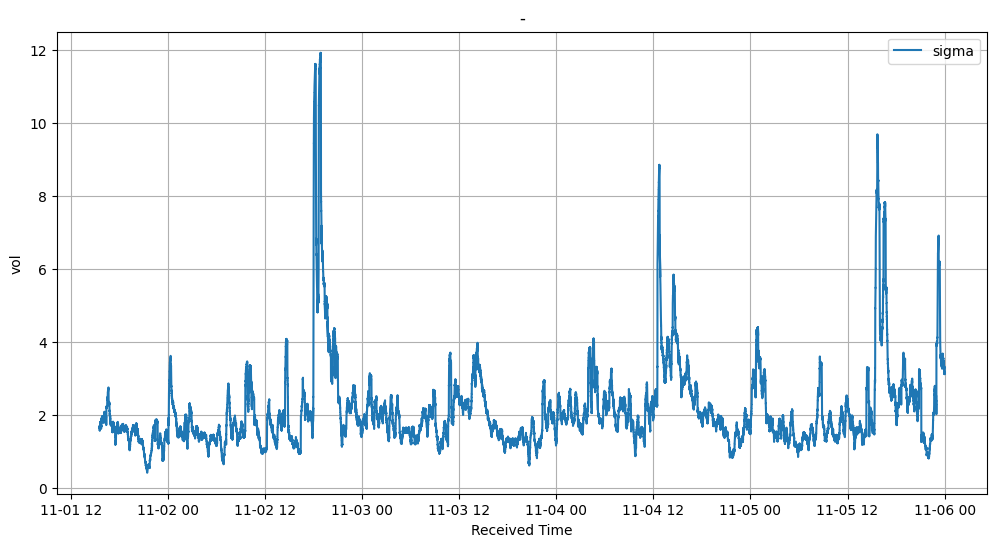

In [21]:

plt.figure(figsize=(12, 6))
plt.plot(resampled_mids['sigma_tick_per_sqrt_second'], label='sigma')
plt.xlabel('Received Time')
plt.ylabel('vol')
plt.title("-")
plt.legend()
plt.grid(True)
plt.show()

## Estimation of A and k


In [22]:
trades.set_index('received_time', inplace=True)
trades.index = pd.to_datetime(trades.index)
mkt_sample = trades[resampled_mids.index[0]:]['price']
mkt_sample.index = mkt_sample.index.floor(sample_size)
trades = trades.reset_index()

In [23]:
books["mid"].iloc[0]

18.817

In [24]:

# create a delta list using appropriate distances
tick_size_in_pct = (100*tick_size)/books["mid"].iloc[0]
basis_point = (books["mid"].iloc[0] * 0.0001) #* 10
basis_point_in_ticks = basis_point/tick_size


print(f"tick_size: {tick_size}, basis_point_in_delta: {basis_point}, basis_point_in_ticks {basis_point_in_ticks}")

#deltalist = np.linspace(basis_point ,basis_point*10, 10) #list of 1 bsp - 10bsp (1bsp == 0.01 %)
deltalist = np.linspace(basis_point ,basis_point*20, 10) #list of 1 bsp - 10bsp (1bsp == 0.01 %)
deltalist += basis_point*5


# For some reason, linspace will add very far our decimals
#deltalist = [np.round(x,1) for x in deltalist]

deltadict = {}
deltadict_bid= {}
deltadict_ask = {}

deltadict_bid_ticks = {}
deltadict_ask_ticks = {}
deltadict_ticks = {}

grouped_mkt_sample = mkt_sample.groupby(pd.Grouper(freq=sample_size))

for price_delta in deltalist:
    print(price_delta)
    resampled_mids['bid'] = resampled_mids['mid'] - price_delta
    resampled_mids['ask']  = resampled_mids['mid'] + price_delta
    
    # Calculate the minimum for each group in grouped_mkt_sample
    grouped_min_df = grouped_mkt_sample.min().reset_index(name='grouped_min')
    grouped_max_df = grouped_mkt_sample.max().reset_index(name='grouped_max')

    # Assuming 'received_time' is the name of the datetime index column
    grouped_df = pd.merge(grouped_min_df, grouped_max_df, on='received_time')

    # Merge with resampled_mids
    merged_df = pd.merge(resampled_mids, grouped_df, left_index=True, right_on='received_time', how='left')

    # Set the index of merged_df to the index of resampled_mids
    merged_df.index = resampled_mids.index

    # Perform vectorized comparison
    bid_limit_order_hit = merged_df['grouped_min'] < merged_df['bid']
    ask_limit_order_hit = merged_df['grouped_max'] > merged_df['ask']
    #print(bid_limit_order_hit)
 
    # Combine the two into a single signal (performs a bitwise OR operation combines T and F signals)
    limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

    #add hit to the last, so we have a big diff for deltas that only have 1-2 trades
    limit_order_hit.iloc[-1] = True
    bid_limit_order_hit.iloc[-1] = True
    ask_limit_order_hit.iloc[-1] = True
    
    # calculate the timedelta in seconds between limit order hits
    deltas_bid = pd.Series(bid_limit_order_hit[bid_limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
    deltas_ask = pd.Series(ask_limit_order_hit[ask_limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
    deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

    deltadict_bid[price_delta] = deltas_bid
    deltadict_ask[price_delta] = deltas_ask
    deltadict[price_delta] = deltas

    deltadict_bid_ticks[price_delta/tick_size] = deltas_bid
    deltadict_ask_ticks[price_delta/tick_size] = deltas_ask
    deltadict_ticks[price_delta/tick_size] = deltas

tick_size: 0.001, basis_point_in_delta: 0.0018817, basis_point_in_ticks 1.8817
0.0112902
0.015262677777777778
0.019235155555555557
0.023207633333333335
0.027180111111111113
0.03115258888888889
0.03512506666666667
0.03909754444444445
0.043070022222222226
0.0470425


In [25]:
# calculate lambdas ("arrival rate", average N of events per unit of time)
#  of orders hitting limit orders. 1/mean waiting time of a specific delta
lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
lambdas_bid = pd.DataFrame([[key,1/deltadict_bid[key].mean()] for key in deltadict_bid.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
lambdas_ask = pd.DataFrame([[key,1/deltadict_ask[key].mean()] for key in deltadict_ask.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')

lambdas_ticks = pd.DataFrame([[key,1/deltadict_ticks[key].mean()] for key in deltadict_ticks.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
lambdas_bid_ticks = pd.DataFrame([[key,1/deltadict_bid_ticks[key].mean()] for key in deltadict_bid_ticks.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
lambdas_ask_ticks = pd.DataFrame([[key,1/deltadict_ask_ticks[key].mean()] for key in deltadict_ask_ticks.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
                       
lambdas_ticks


,lambda_delta
delta,
11.290200,0.005665
15.262678,0.002914
19.235156,0.001598
23.207633,0.001117
27.180111,0.000840
31.152589,0.000552
35.125067,0.000439
39.097544,0.000336
43.070022,0.000264


In [26]:
# Define a function of the expnential curve we are trying to fit
def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y
# Fit the curve to our set of lambdas
def fit_curve(exp_fit, delta_values, lambdas):
    paramsB, cv = scipy.optimize.curve_fit(exp_fit, delta_values, lambdas)
    #paramsB, cv = scipy.optimize.curve_fit(exp_fit,  np.arange(1, 11), np.array(lambdas['lambda_delta'].values))
    A, k = paramsB
    return A, k

In [27]:
A, k = fit_curve(exp_fit, np.array(lambdas.index)/(books["mid"].iloc[0]/100), np.array(lambdas['lambda_delta'].values))
print("lambda/delta in pct")
print(f"A: {A},k: {k}")
A_backtest_as = A
k_backtest_as = k


A, k = fit_curve(exp_fit, np.array(lambdas_ticks.index), np.array(lambdas_ticks['lambda_delta'].values))
print("lambda/delta in ticks")
print(f"A: {A},k: {k}")
A_backtest_glft = A
k_backtest_glft = k

lambda/delta in pct
A: 0.026097632509434594,k: 25.957973781678717
lambda/delta in ticks
A: 0.026097900592294627,k: 0.1379503602825695


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_8670/2097060987.py:3: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)


A_buy 0.014971518808868354, A_sell 0.01139352555564662, A_avg 0.026097632509434594
k_buy 27.920899981556715, k_sell 23.276762828587167, k_avg 25.957973781678717


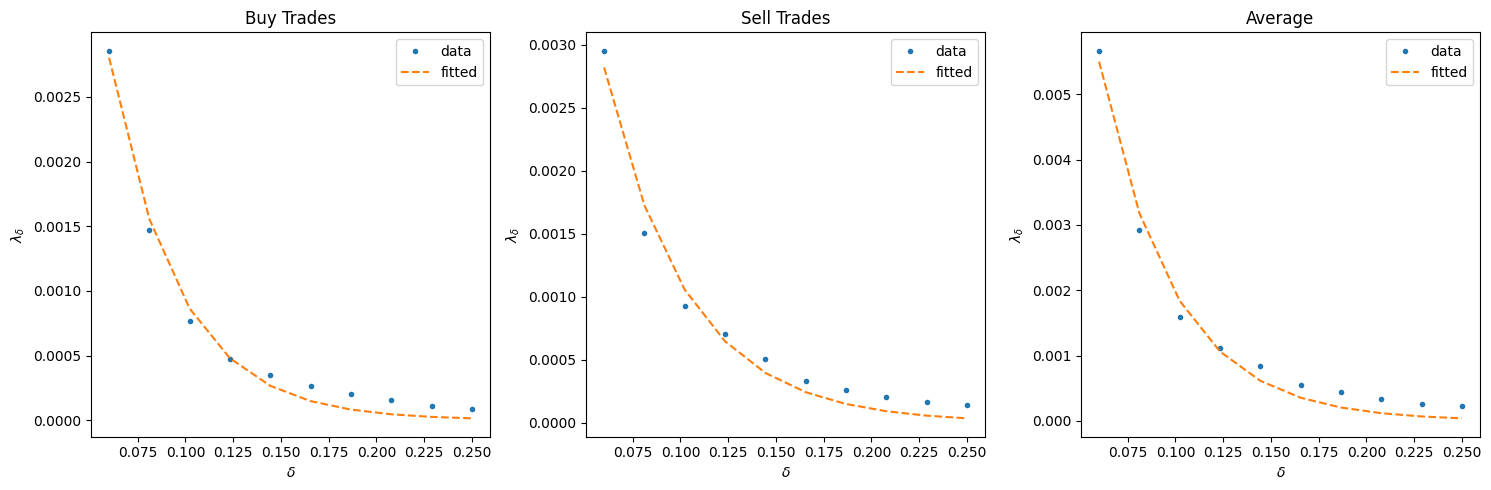

In [28]:

A, k = fit_curve(exp_fit, np.array(lambdas.index)/(books["mid"].iloc[0]/100), np.array(lambdas['lambda_delta'].values))
A_buy, k_buy = fit_curve(exp_fit, np.array(lambdas_bid.index)/(books["mid"].iloc[0]/100), np.array(lambdas_bid['lambda_delta'].values))
A_sell, k_sell = fit_curve(exp_fit, np.array(lambdas_ask.index)/(books["mid"].iloc[0]/100), np.array(lambdas_ask['lambda_delta'].values))

print(f"A_buy {A_buy}, A_sell {A_sell}, A_avg {A}")
print(f"k_buy {k_buy}, k_sell {k_sell}, k_avg {k}")

fig, ax = plt.subplots(1, 3, figsize=(15,5))
# Buy trades
ax[0].plot(np.array(lambdas_bid.index)/(books["mid"].iloc[0]/100), np.array(lambdas_bid['lambda_delta'].values), '.', label="data")
ax[0].plot(np.array(lambdas_bid.index)/(books["mid"].iloc[0]/100), exp_fit(np.array(lambdas_bid.index)/(books["mid"].iloc[0]/100), A_buy, k_buy), '--', label="fitted")
ax[0].set_title('Buy Trades')
ax[0].set_xlabel('$\delta$')
ax[0].set_ylabel('$\lambda_\delta$')
ax[0].legend()

# Sell trades
ax[1].plot(np.array(lambdas_ask.index)/(books["mid"].iloc[0]/100), np.array(lambdas_ask['lambda_delta'].values), '.', label="data")
ax[1].plot(np.array(lambdas_ask.index)/(books["mid"].iloc[0]/100), exp_fit(np.array(lambdas_ask.index)/(books["mid"].iloc[0]/100), A_sell, k_sell), '--', label="fitted")
ax[1].set_title('Sell Trades')
ax[1].set_xlabel('$\delta$')
ax[1].set_ylabel('$\lambda_\delta$')
ax[1].legend()

# Average
ax[2].plot(np.array(lambdas.index)/(books["mid"].iloc[0]/100), np.array(lambdas['lambda_delta'].values), '.', label="data")
ax[2].plot(np.array(lambdas.index)/(books["mid"].iloc[0]/100), exp_fit(np.array(lambdas.index)/(books["mid"].iloc[0]/100), A, k), '--', label="fitted")
ax[2].set_title('Average')
ax[2].set_xlabel('$\delta$')
ax[2].set_ylabel('$\lambda_\delta$')
ax[2].legend()

plt.tight_layout()
plt.show()

#### now lets calculate a rolling estimation of a and k

In [29]:
from functools import partial

def calc_kappa(window, mkt_sample):
    mid_price = window['mid'].iloc[0]
    basis_point = (mid_price * 0.0001) 
    deltalist = np.linspace(basis_point ,basis_point*10, 10) #list of 1 bsp - 10bsp (1bsp == 0.01 %)

    # For some reason, linspace will add very far our decimals
    #deltalist = [np.round(x,1) for x in deltalist]

    deltadict = {}
    deltadict_bid= {}
    deltadict_ask = {}

    #print(window)
    window = pd.DataFrame(window, columns=['mid'])

    #window = window.to_frame(name='mid')
    
    #print(window)
    mkt_sample = mkt_sample[mkt_sample.index.isin(window.index)]
    #print(mkt_sample)
    grouped_mkt_sample = mkt_sample.groupby(pd.Grouper(freq=sample_size))
    

    for price_delta in deltalist:
        #print(price_delta)
        
        window['bid'] = window['mid'] - price_delta
        window['ask'] = window['mid'] + price_delta
        
        
        # Calculate the minimum for each group in grouped_mkt_sample
        grouped_min_df = grouped_mkt_sample.min().reset_index(name='grouped_min')
        grouped_max_df = grouped_mkt_sample.max().reset_index(name='grouped_max')
        grouped_df = pd.merge(grouped_min_df, grouped_max_df, on='received_time')

        # Merge with resampled_mids
        merged_df = pd.merge(window, grouped_df, left_index=True, right_on='received_time', how='left')

    
        # Set the index of merged_df to the index of resampled_mids
        merged_df.index = window.index

        

        # Perform vectorized comparison
        bid_limit_order_hit = merged_df['grouped_min'] < merged_df['bid']
        ask_limit_order_hit = merged_df['grouped_max'] > merged_df['ask']
    
        # Combine the two into a single signal (performs a bitwise OR operation combines T and F signals)
        limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

        #add hit to the last and first, so we have a big diff for deltas that only have 1-2 trades 
        limit_order_hit.iloc[-1] = True
        bid_limit_order_hit.iloc[-1] = True
        ask_limit_order_hit.iloc[-1] = True
        limit_order_hit.iloc[0] = True
        bid_limit_order_hit.iloc[0] = True
        ask_limit_order_hit.iloc[0] = True
        
        # calculate the timedelta in seconds between limit order hits
        if sum(bid_limit_order_hit) >= 2:
            deltas_bid = pd.Series(bid_limit_order_hit[bid_limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
            deltadict_bid[price_delta] = deltas_bid

        if sum(ask_limit_order_hit) >= 2:
            deltas_ask = pd.Series(ask_limit_order_hit[ask_limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
            deltadict_ask[price_delta] = deltas_ask

        if sum(limit_order_hit) >= 2:
            deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
            deltadict[price_delta] = deltas


    lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                    columns=['delta','lambda_delta']).set_index('delta')
    lambdas_bid = pd.DataFrame([[key,1/deltadict_bid[key].mean()] for key in deltadict_bid.keys()],
                        columns=['delta','lambda_delta']).set_index('delta')
    lambdas_ask = pd.DataFrame([[key,1/deltadict_ask[key].mean()] for key in deltadict_ask.keys()],
                    columns=['delta','lambda_delta']).set_index('delta')
    
    #lambdas = lambdas.dropna(subset=['lambda_delta'])
    #lambdas_bid = lambdas_bid.dropna(subset=['lambda_delta'])
    #lambdas_ask = lambdas_ask.dropna(subset=['lambda_delta'])

    try:
        
        A, k = fit_curve(exp_fit, np.array(lambdas.index)/(mid_price/100), np.array(lambdas['lambda_delta'].values))
    except (ValueError, RuntimeError,TypeError):
        A, k = np.nan, np.nan
    try:
        A_buy, k_buy = fit_curve(exp_fit, np.array(lambdas_bid.index)/(mid_price/100), np.array(lambdas_bid['lambda_delta'].values))
    except (ValueError, RuntimeError,TypeError):
        A_buy, k_buy = np.nan, np.nan
    try:
        A_sell, k_sell = fit_curve(exp_fit, np.array(lambdas_ask.index)/(mid_price/100), np.array(lambdas_ask['lambda_delta'].values))
    except (ValueError, RuntimeError,TypeError):
        A_sell, k_sell = np.nan, np.nan  
    

    return A, k, A_buy, k_buy, A_sell, k_sell

window_size = '60S'  # Example: 60 seconds rolling window

# Initialize empty lists for each metric
index = []
A_values = []
k_values = []
A_buy_values = []
k_buy_values = []
A_sell_values = []
k_sell_values = []

window_size = 200

# Loop through each rolling window of resampled_mids with progress bar
for i in tqdm(range(0, len(mkt_sample) - window_size + 1, 200), desc="Processing rolling windows"):
    mkt_sample_window = mkt_sample.iloc[i:i+window_size]

    window_data = resampled_mids.loc[resampled_mids.index.isin(mkt_sample_window.index)]
   

    # Apply calc_kappa on the window
    A, k, A_buy, k_buy, A_sell, k_sell = calc_kappa(window_data, mkt_sample=mkt_sample)
    
    # Append the results to the respective lists
    index.append(window_data.index[-1])
    A_values.append(A)
    k_values.append(k)
    A_buy_values.append(A_buy)
    k_buy_values.append(k_buy)
    A_sell_values.append(A_sell)
    k_sell_values.append(k_sell)

# Create a DataFrame from the lists and align the index
df_results = pd.DataFrame({
    
    'A': A_values,
    'k': k_values,
    'A_buy': A_buy_values,
    'k_buy': k_buy_values,
    'A_sell': A_sell_values,
    'k_sell': k_sell_values
}, index=index)#index=resampled_mids.index[window_size-1:]
#print(df_results)
# Concatenate the results to the original resampled_mids
#resampled_mids = pd.concat([resampled_mids, df_results], axis=1)



Processing rolling windows:  84%|████████▍ | 274/327 [00:11<00:02, 21.82it/s]/Users/miguelmeier/opt/anaconda3/envs/ser_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/miguelmeier/opt/anaconda3/envs/ser_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Processing rolling windows: 100%|██████████| 327/327 [00:14<00:00, 23.20it/s]


In [30]:
#merge results
df_results = df_results.rename_axis('received_time')
books = pd.merge_asof(books, df_results[["A", "k", "A_buy", "k_buy", "A_sell", "k_sell"]], on='received_time', direction='backward') #backward-> no future information

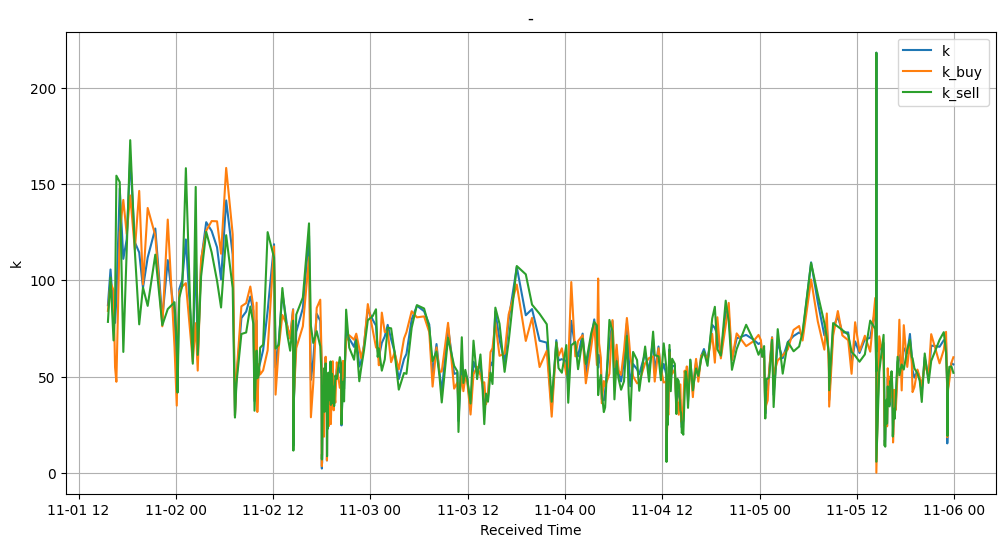

In [31]:
plt.figure(figsize=(12, 6))
df_results = df_results.ffill()
plt.plot(df_results['k'], label='k')
plt.plot(df_results['k_buy'], label='k_buy')
plt.plot(df_results['k_sell'], label='k_sell')
#plt.plot(resampled_mids['sigma_rolling_h'], label='sigma_rolling_h')
#plt.plot(resampled_mids['sigma_rolling_d'], label='sigma_rolling_d')
plt.xlabel('Received Time')
plt.ylabel('k')
plt.title("-")
plt.legend()
plt.grid(True)
plt.show()

implementation of a prediction

In [32]:
#pred
def pred(x_imbalance, x_count_imb, x_limit_imb, x_mark_price_spread):
    def pred_mark_price_spread(mps):
        if mps >= 0:
            return 0.181
        else:
            return -0.181

    def linear_limit_imb(x):
        m,b = 0.12797737, -0.00181614
        return m*x + b

    def poly3_count_imb(x):
        a,b,c,d = 0.1331432,  0.01489431, 0.04339085, 0.01201319
        return a*x**3 + b*x**2 + c*x + d

    def poly3_imbalance(x):
        a,b,c,d = 0.25595057,  0.04047296,  0.12627636, -0.01489497
        return a*x**3 + b*x**2 + c*x + d

    pred_ = []
    pred_.append(poly3_imbalance(x_imbalance))
    pred_.append(poly3_count_imb(x_count_imb))
    pred_.append(linear_limit_imb(x_limit_imb))
    pred_.append(pred_mark_price_spread(x_mark_price_spread))

    result = np.mean(pred_)

    return result
    
books["pred"] = books.apply(lambda row: pred(row["ob_imbalance_3"], 
                                             row["trade_count_imbalance"], 
                                             row["limit_imbalance"], 
                                             row["mark_price_spread"]), axis=1)


window_size = 10000  # Replace with the desired window size

# Calculate the rolling mean and standard deviation
rolling_mean = books["pred"].rolling(window=window_size).mean()
rolling_std = books["pred"].rolling(window=window_size).std()

# Calculate the standardized values using the rolling mean and standard deviation
books["pred"] = (books["pred"] - rolling_mean) / rolling_std

books["pred"] = books["pred"].rolling(window=50).mean()
books.dropna(inplace=True)

In [33]:
def calculate_target_inventory(mid_price, base_asset_amount, quote_asset_amount, inventory_target):
    price = mid_price 
    # Base asset value in quote asset prices (usually USDT)
    base_value = base_asset_amount * price

    # Total inventory value in quote asset prices
    inventory_value = base_value + quote_asset_amount

    # Target base asset value in quote asset prices
    target_inventory_value = inventory_value * inventory_target

    # Target base asset amount
    target_inventory_amount = target_inventory_value / price

    return target_inventory_amount

def calculate_inventory(mid_price, base_asset_amount, quote_asset_amount):
    price = mid_price

    # Base asset value in quote asset prices
    base_value = base_asset_amount * price

    # Total inventory value in quote asset prices
    inventory_value_quote = base_value + quote_asset_amount

    # Total inventory value in base asset prices
    inventory_value_base = inventory_value_quote / price

    return inventory_value_base
    
def run_backtest_as(books, trades, gamma, order_size, A, k, sigma, tick_size, start_usd_val, additional_spread_pct, vol_multiplier, adj1=1, adj2=1):
  
    # Filter the DataFrame
    start_datetime = books['received_time'].iloc[0]
    trades = trades[trades['received_time'] > start_datetime].reset_index(drop=True)

    # create a 
    
    #create new col
    trades["fill"] = np.NAN


    inventory_target = 0.5

    #start_usd_val = 200
    start_base_asset_amount = (start_usd_val/2)/books['mid'].iloc[0]
    start_quote_asset_amount = (start_usd_val/2)

    mid_array = books['mid'].values
    sigma_array = books['sigma'].values
    best_bid_array = books['bid_0_price'].values
    best_ask_array = books['ask_0_price'].values
    vwap_array = books['rolling_vwap_5_trades'].values
    #imb
    imbalance = books['ob_imbalance_3'].values
    
    #prediction arrays
    pred = books["pred"].values
    
    N = len(books)

    base_asset_amount = np.zeros(N+1)
    base_asset_amount[:] = start_base_asset_amount
    quote_asset_amount = np.zeros(N+1)
    quote_asset_amount[:] = start_quote_asset_amount

    
    # Initialize empty array for pnl
    pnl = np.zeros(N+1)

    #mid
    mid_p = np.zeros(N+1)

    
    # Inventory
    q = np.zeros(N+1)

    # Capital
    x = np.zeros(N+1)
    
    # Spread
    spr = np.zeros(N+1)

    # Ask limit orders
    r_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)

    # Bid limit orders
    r_b = np.zeros(N+1)

    #pos
    position = np.zeros(N+1)
    q_parameter = np.zeros(N+1)

    bid_spread_pct = np.zeros(N+1)
    ask_spread_pct = np.zeros(N+1)

    received_time = []
    #trades index
    trades_index = 0

    # Iterate through each second
    for i in tqdm(range(len(books)-1)):
        
        # Calculate our reservation price
        received_time.append(books['received_time'].iloc[i])
        mid = mid_array[i]
        sigma = sigma_array[i]
        best_bid = best_bid_array[i]
        best_ask = best_ask_array[i]
        mid_p[i] = mid

        q_target = calculate_target_inventory(mid_p[i], base_asset_amount[i], quote_asset_amount[i], inventory_target)
        inventory = calculate_inventory(mid_p[i], base_asset_amount[i], quote_asset_amount[i])
        q_parameter_ = (base_asset_amount[i] - q_target) / inventory
        q_parameter[i] = q_parameter_
        
        # Calculate our spread
        spread = (gamma * (sigma* vol_multiplier)**2  + (2 / gamma) * np.log(1 + (gamma / k))) * (mid_p[i]/100)
        spr[i] = spread
        spread =( spread / 2) + (additional_spread_pct* (mid_p[i]/100))

        # Calculate our reservation price
        fair = mid_p[i] + (pred[i] * (spread))
        r[i] = (fair) - (((position[i])* gamma * sigma**2) * (mid_p[i]/100))

        # Define our limit orders
        r_a[i] = max((r[i] + spread), best_ask)
        r_b[i] = min((r[i] - spread), best_bid)

        bid_spread_pct[i] = round(((abs(mid_p[i] - r_b[i]) / mid_p[i]) * 100), 3)
        ask_spread_pct[i] = round(((abs(mid_p[i] - r_a[i]) / mid_p[i]) * 100), 3)
        
        # Do not buy or sell unless we get a feasible market order
        sell = 0
        buy  = 0

        next_books_datetime = books['received_time'].iloc[i+1]

        # Loop through rows of df
        for row in trades.iloc[trades_index:].itertuples():
            if row.received_time < next_books_datetime:
                
                if row.side == "sell":
                    if row.price <= r_b[i]:
                        buy += row.quantity
                        #mark as filled
                        trades.at[trades_index, 'fill'] = row.price
                else:
                    if row.price >= r_a[i]:
                        sell += row.quantity
                        #mark as filled
                        trades.at[trades_index, 'fill'] = row.price

                trades_index += 1

            else:
                break
        
        #only add up to our max ordersize
        sell_usd = sell * mid_p[i]
        buy_usd = buy * mid_p[i]
        
        if sell_usd> order_size:
            sell_usd = order_size
            sell = order_size/ mid_p[i]
        if buy_usd > order_size:
            buy_usd = order_size
            buy = order_size/ mid_p[i]
            

        #pos
        position[i+1] = position[i] + (buy_usd/order_size) - (sell_usd/order_size)
        base_asset_amount[i+1] = base_asset_amount[i] + buy - sell
        quote_asset_amount[i+1] = quote_asset_amount[i] - (buy*r_b[i]) + (sell*r_a[i])

      
        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        #     # Calculate new capital
        x[i+1] = x[i] + sell*(r_a[i]) - buy*(r_b[i])

        #     # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]* mid
        

    return trades, {'pnl':pnl[:-2], 'quote_asset_amount':quote_asset_amount[:-2],'base_asset_amount':base_asset_amount[:-2],'position':position[:-2], 'mid':mid_p[:-2], 'bid_spread_pct':bid_spread_pct[:-2], 'ask_spread_pct':ask_spread_pct[:-2], 'received_time':received_time, 'x':x[:-2], 'q':q[:-2], "q_parameter":q_parameter[:-2], 'spread':spr[:-2], 'r':r[:-2], 'r_a':r_a[:-2], 'r_b':r_b[:-2]} 
    



In [34]:
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2
    
def run_backtest_glft(books, trades, gamma, order_size, A, k, sigma, tick_size, start_usd_val, additional_spread_pct, vol_multiplier, adj1=1, adj2=1, with_pred = True):
    """
    this strat uses these units: k: lambda/(ticks from mid price), sigma: ticks per square root of a second (this was used for 100ms orderupdates)
    """
    
    start_datetime = books['received_time'].iloc[0]
    trades = trades[trades['received_time'] > start_datetime].reset_index(drop=True)
    #create new col
    trades["fill"] = np.NAN


    inventory_target = 0.5

    start_base_asset_amount = (start_usd_val/2)/books['mid'].iloc[0]
    start_quote_asset_amount = (start_usd_val/2)

    mid_array = books['mid'].values
    sigma_array = books['sigma_tick_per_sqrt_second'].values
    best_bid_array = books['bid_0_price'].values
    best_ask_array = books['ask_0_price'].values

    #prediction arrays
    pred = books["pred"].values
    
    N = len(books)

    base_asset_amount = np.zeros(N+1)
    base_asset_amount[:] = start_base_asset_amount
    quote_asset_amount = np.zeros(N+1)
    quote_asset_amount[:] = start_quote_asset_amount

    # Initialize empty array for pnl
    pnl = np.zeros(N+1)

    #mid
    mid_p = np.zeros(N+1)

    # Inventory
    q = np.zeros(N+1)

    # Capital
    x = np.zeros(N+1)
    
    # Spread
    spr = np.zeros(N+1)

    # Ask limit orders
    r_a = np.zeros(N+1)
    r_a2 = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)

    # Bid limit orders
    r_b = np.zeros(N+1)
    r_b2 = np.zeros(N+1)

    #pos
    position = np.zeros(N+1)
    q_parameter = np.zeros(N+1)

    bid_spread_pct = np.zeros(N+1)
    ask_spread_pct = np.zeros(N+1)

    received_time = []
    #trades index
    trades_index = 0

    # Iterate through each second
    for i in tqdm(range(len(books)-1)):
        
        # Find the date for the given iteration
        
         # Calculate our reservation price
        received_time.append(books['received_time'].iloc[i])
        mid = books['mid'].iloc[i]
        mid_p[i] = mid
        sigma = sigma_array[i] 
        #k = books['kappa'].iloc[i]
        #A = books['alpha'].iloc[i]
        best_bid = books['bid_0_price'].iloc[i]
        best_ask = books['ask_0_price'].iloc[i]

        c1, c2 = compute_coeff(gamma, gamma, 1, A, k)
        
        half_spread = (c1 + 1 / 2 * c2 * (sigma* vol_multiplier)) * adj1
        skew = c2 * sigma * adj2

        if with_pred:
            fair = mid_p[i] + (pred[i] * (half_spread*2*tick_size))
        else:
            fair = mid_p[i] 

        r[i] = fair

        bid_depth = (half_spread + (skew * position[i]))
        ask_depth = (half_spread - (skew * position[i]))

        bid_price = min((fair - (bid_depth)*tick_size), best_bid) 
        ask_price = max((fair + (ask_depth)*tick_size), best_ask) 
        bid_price2 = min((fair - (2*bid_depth)*tick_size), best_bid) 
        ask_price2 = max((fair + (2*ask_depth)*tick_size), best_ask) 

        r_a[i] = ask_price + (additional_spread_pct* (mid_p[i]/100))
        r_b[i] = bid_price - (additional_spread_pct* (mid_p[i]/100))
        r_a2[i] = ask_price + (additional_spread_pct* (mid_p[i]/100))
        r_b2[i] = bid_price - (additional_spread_pct* (mid_p[i]/100))

        bid_spread_pct[i] = round(((abs(mid_p[i] - r_b[i]) / mid_p[i]) * 100), 3)
        ask_spread_pct[i] = round(((abs(mid_p[i] - r_a[i]) / mid_p[i]) * 100), 3)
        
        # Do not buy or sell unless we get a feasible market order
        sell = 0
        buy  = 0
        sell2 = 0
        buy2  = 0

        next_books_datetime = books['received_time'].iloc[i+1]
        # Loop through rows of df
        for row in trades.iloc[trades_index:].itertuples():
            if row.received_time < next_books_datetime:
                
                if row.side == "sell":
                    
                    if row.price <= r_b[i]:
                        buy += row.quantity
                        #mark as filled
                        trades.at[trades_index, 'fill'] = row.price


                    # if row.price <= r_b2[i]:
                    #     buy2 += row.quantity
                    #     #mark as filled
                    #     trades.at[trades_index, 'fill'] = row.price

                    #r_b[i] = r_b[i] -(half_spread*3*tick_size) #if we see a trade in ths direction stop quoting
                else:
                    
                    if row.price >= r_a[i]:
                        sell += row.quantity
                        #mark as filled
                        trades.at[trades_index, 'fill'] = row.price

                    # if row.price >= r_a2[i]:
                    #     sell2 += row.quantity
                    #     #mark as filled
                    #     trades.at[trades_index, 'fill'] = row.price

                    #r_a[i] = r_a[i] +(half_spread*3*tick_size) #if we see a trade in ths direction stop quoting

                trades_index += 1

            else:
                break
        
        #only add up to our max ordersize
        sell_usd = sell * mid_p[i]
        buy_usd = buy * mid_p[i]
        
        if sell_usd> order_size:
            sell_usd = order_size
            sell = order_size/ mid_p[i]
        if buy_usd > order_size:
            buy_usd = order_size
            buy = order_size/ mid_p[i]


        # if sell2 > order_size:
        #     sell2 = order_size
        # if buy2 > order_size:
        #     buy2 = order_size
            
        

        #pos
        position[i+1] = position[i] + (buy_usd/order_size) - (sell_usd/order_size) #+ (buy2/order_size) - (sell2/order_size)
        
        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell + buy2 - sell2

        #     # Calculate new capital
        if not np.isnan(x[i] + sell*(r_a[i]) - buy*(r_b[i]) + sell2*(r_a2[i]) - buy2*(r_b2[i])):
            x[i+1] = x[i] + sell*(r_a[i]) - buy*(r_b[i]) + sell2*(r_a2[i]) - buy2*(r_b2[i])
        else:
            x[i+1] = x[i]

        #     # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1] * mid

    return trades, {'pnl':pnl[:-2], 'position':position[:-2], 'mid':mid_p[:-2], 'bid_spread_pct':bid_spread_pct[:-2], 'ask_spread_pct':ask_spread_pct[:-2], 'received_time':received_time, 'x':x[:-2], 'q':q[:-2], 'spread':spr[:-2], 'r':r[:-2], 'r_a':r_a[:-2], 'r_b':r_b[:-2]} 
    
    

## backtest

Run a sample backtest of the Guéant–Lehalle–Fernandez-Tapia model without predictions

In [35]:

sigma = 0.07 
gamma = 0.05
A = A_backtest_glft 
k = k_backtest_glft 
order_size = 10 #in usd
start_usd_val = 200

additional_spread_pct = 0.02
vol_multiplier = 2

adj1=1
adj2=0.5 #this is for the skew

resampled_books = books

# run test
trades_with_fill_mark, res = run_backtest_glft(resampled_books[-50000:], trades, gamma, order_size, A, k, sigma, tick_size, start_usd_val, additional_spread_pct, vol_multiplier, adj1, adj2, False)
# Save the PnL to a DataFrame
result = pd.DataFrame(res)


100%|██████████| 49999/49999 [11:44<00:00, 71.01it/s]  


total_vol_usd: 15091.191968423718
average spread: 0.04100982079358078


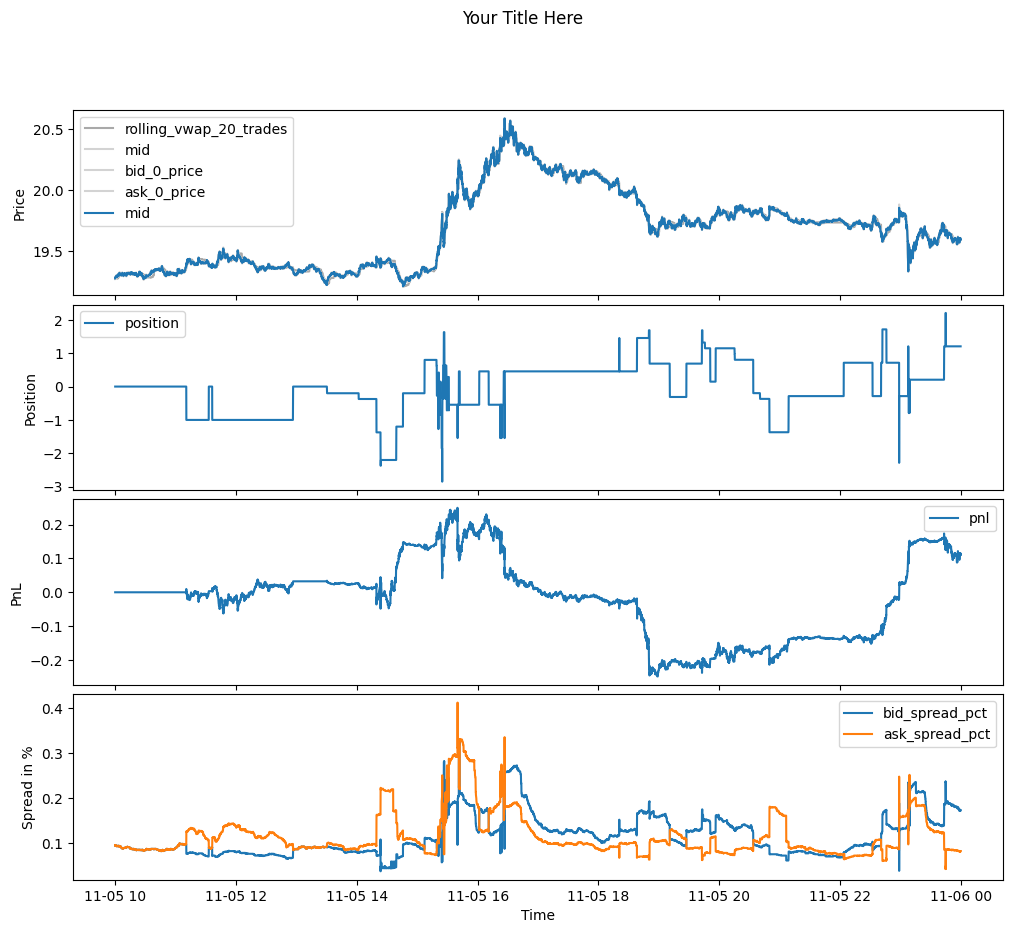

In [37]:
total_vol_usd = (result['position'].abs().sum() * order_size)/ result["mid"].iloc[-1]
print(f"total_vol_usd: {total_vol_usd}")


print(f"average spread: {books['spread_pct'].mean()}")

start_datetime = result['received_time'].iloc[0]
books_plt = books[books['received_time'] > start_datetime].reset_index(drop=True)
trades_plt = trades[trades['received_time'] > start_datetime].reset_index(drop=True)

# Creating the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)  # Adjust the space between plots

# Plotting on each subplot
# Subplot 1
axes[0].plot(books_plt['received_time'], books_plt["rolling_vwap_20_trades"], label='rolling_vwap_20_trades', color="darkgray")
axes[0].plot(books_plt['received_time'], books_plt["mid"], label='mid', color="lightgray")
axes[0].plot(books_plt['received_time'], books_plt["bid_0_price"], label='bid_0_price', color="lightgray")
axes[0].plot(books_plt['received_time'], books_plt["ask_0_price"], label='ask_0_price', color="lightgray")
axes[0].plot(result['received_time'], result["mid"], label='mid')

axes[0].set_ylabel('Price')

# Subplot 2
axes[1].plot(result['received_time'], result['position'], label='position')
axes[1].set_ylabel('Position')

# Subplot 3
axes[2].plot(result['received_time'], result['pnl'], label='pnl')
axes[2].set_ylabel('PnL')

# Subplot 4
axes[3].plot(result['received_time'], result['bid_spread_pct'], label='bid_spread_pct')
axes[3].plot(result['received_time'], result['ask_spread_pct'], label='ask_spread_pct')
axes[3].set_ylabel('Spread in %')

# Set the x-axis label
axes[-1].set_xlabel('Time')

# Add a title
fig.suptitle('Your Title Here')
for ax in axes:
    ax.legend()

# Show the plot
plt.show()

Run a sample backtest of the Guéant–Lehalle–Fernandez-Tapia model with predictions

In [38]:
sigma = 0.07 
gamma = 0.05
A = A_backtest_glft 
k = k_backtest_glft 
order_size = 10 #in usd
start_usd_val = 200

additional_spread_pct = 0.02
vol_multiplier = 2

adj1=1
adj2=0.5 #this is for the skew

resampled_books = books

# run test
trades_with_fill_mark, res = run_backtest_glft(resampled_books[-50000:], trades, gamma, order_size, A, k, sigma, tick_size, start_usd_val, additional_spread_pct, vol_multiplier, adj1, adj2)
# Save the PnL to a DataFrame
result = pd.DataFrame(res)

  0%|          | 0/49999 [00:00<?, ?it/s]

100%|██████████| 49999/49999 [12:36<00:00, 66.06it/s]  


total_vol_usd: 28599.934244605516
average spread: 0.04100982079358078


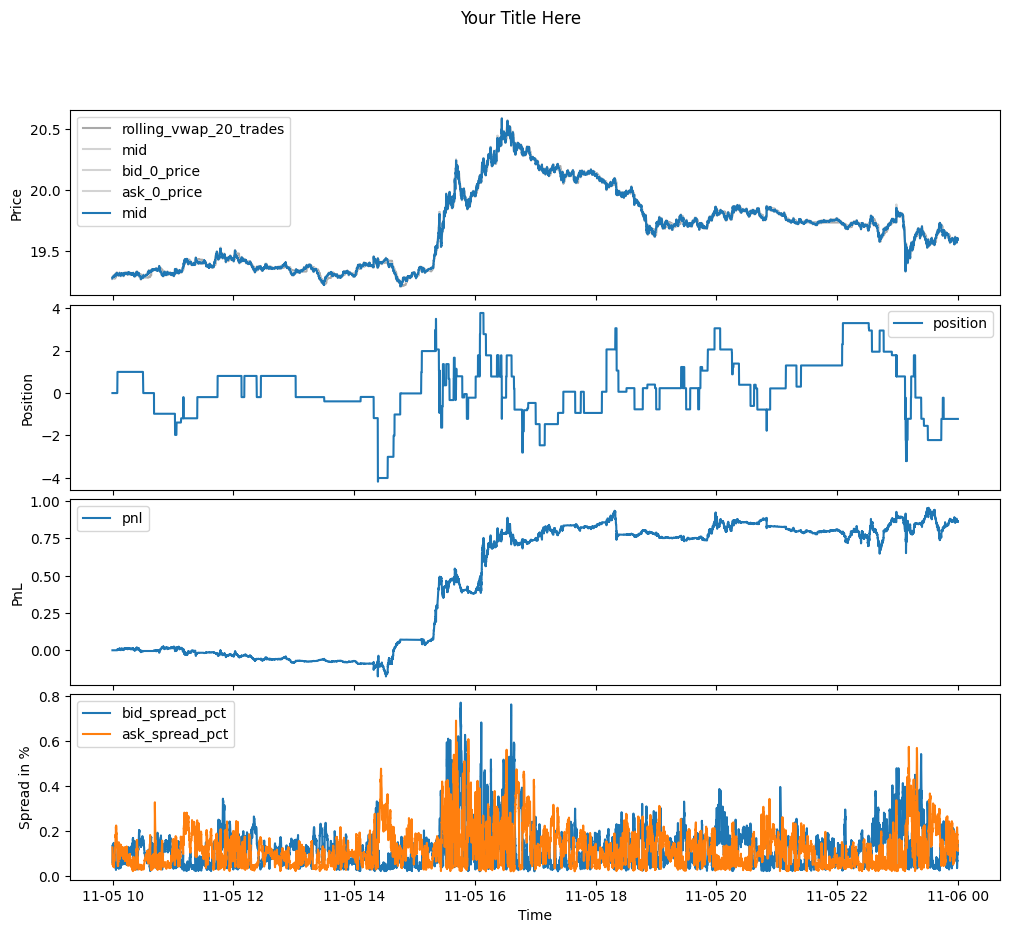

In [39]:
total_vol_usd = (result['position'].abs().sum() * order_size)/ result["mid"].iloc[-1]
print(f"total_vol_usd: {total_vol_usd}")


print(f"average spread: {books['spread_pct'].mean()}")

start_datetime = result['received_time'].iloc[0]
books_plt = books[books['received_time'] > start_datetime].reset_index(drop=True)
trades_plt = trades[trades['received_time'] > start_datetime].reset_index(drop=True)

# Creating the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)  # Adjust the space between plots

# Plotting on each subplot
# Subplot 1
axes[0].plot(books_plt['received_time'], books_plt["rolling_vwap_20_trades"], label='rolling_vwap_20_trades', color="darkgray")
axes[0].plot(books_plt['received_time'], books_plt["mid"], label='mid', color="lightgray")
axes[0].plot(books_plt['received_time'], books_plt["bid_0_price"], label='bid_0_price', color="lightgray")
axes[0].plot(books_plt['received_time'], books_plt["ask_0_price"], label='ask_0_price', color="lightgray")
axes[0].plot(result['received_time'], result["mid"], label='mid')

axes[0].set_ylabel('Price')

# Subplot 2
axes[1].plot(result['received_time'], result['position'], label='position')
axes[1].set_ylabel('Position')

# Subplot 3
axes[2].plot(result['received_time'], result['pnl'], label='pnl')
axes[2].set_ylabel('PnL')

# Subplot 4
axes[3].plot(result['received_time'], result['bid_spread_pct'], label='bid_spread_pct')
axes[3].plot(result['received_time'], result['ask_spread_pct'], label='ask_spread_pct')
axes[3].set_ylabel('Spread in %')

# Set the x-axis label
axes[-1].set_xlabel('Time')

# Add a title
fig.suptitle('Your Title Here')
for ax in axes:
    ax.legend()

# Show the plot
plt.show()